In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import skew
from joblib import dump, load

## Check dataset folder system

TO begin with, we are checking the folder system of our dataset to ensure it's accessed correctly.

In [2]:
dir_raw_dataset = 'data/Furniture_Data'
sub_folders = [sub_folder for sub_folder in os.listdir(dir_raw_dataset) if os.path.isdir(os.path.join(dir_raw_dataset, sub_folder))]
print(sub_folders)

['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']


In **Task 1 EDA & Preprocess**, we already analyze our raw data including removing duplicated images, saving image paths into csv and plotting data distribution. Hence, we will reuse our **df_clean.csv** for further data exploratory.

In [3]:
# Load the dataset for Exploratory Data Analysis purpose
data_eda = pd.read_csv('./data/df_clean.csv')
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81335 entries, 0 to 81334
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  81335 non-null  object
 1   Class    81335 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


## Class distributiuon

In the following plot let us demonstrate the number of entities of each class. This will tell what measures must be taken with the data.

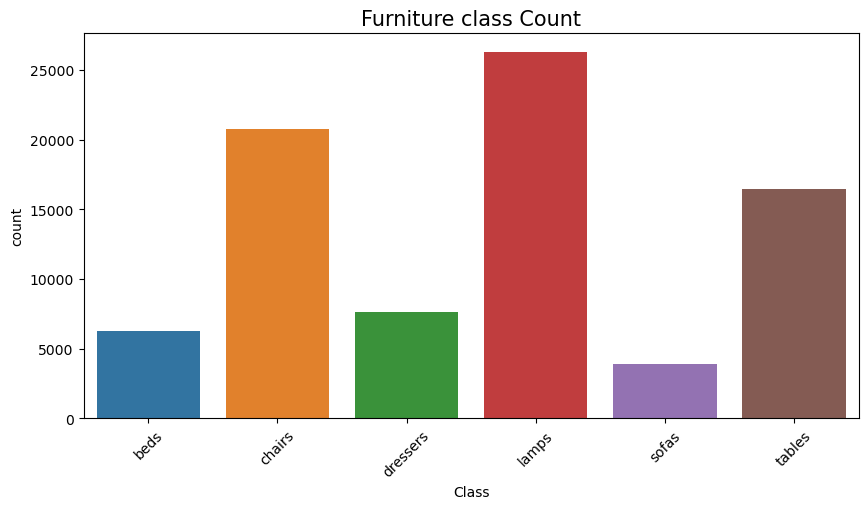

In [4]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data=data_eda, x='Class') 
plt.title("Furniture class Count", fontsize=15)
plt.xticks(rotation=45)
plt.show()

From the graph we can identify that the number of rows of each class differs drastically.

This enables us to perform data resampling to mitigate class imbalance.

## Style distribution

In the same manner as with the class, let us demonstrate the style distribution of each furniture class. Function `get_image_style` will identify the furniture style.

In [5]:
def get_image_style(full_path):
    # Normalize the path to avoid issues with different OS path separators
    normalized_path = os.path.normpath(full_path)
    
    # Split the path into parts
    path_parts = normalized_path.split(os.sep)
    # return path_parts
    
    # Get the last three components of the path
    image_style = path_parts[3]
    
    return image_style

In [6]:
df_style = data_eda['ImgPath'].apply(get_image_style)
data_eda['Style'] = data_eda['ImgPath'].apply(get_image_style)

In [7]:
data_eda = data_eda.reset_index(drop=True)
data_eda.to_csv('./data/df_clean_Task3.csv', index=False)

In [8]:
data_eda.head()

,ImgPath,Class,Style
0,data/Furniture_Data\beds\Asian\20027asian-cano...,beds,Asian
1,data/Furniture_Data\beds\Asian\20109asian-pane...,beds,Asian
2,data/Furniture_Data\beds\Asian\2537asian-platf...,beds,Asian
3,data/Furniture_Data\beds\Asian\2637asian-platf...,beds,Asian
4,data/Furniture_Data\beds\Asian\2709asian-platf...,beds,Asian


In [9]:
style_counts = data_eda.groupby(['Class', 'Style']).size().reset_index(name='counts')
style_counts.head()

,Class,Style,counts
0,beds,Asian,44
1,beds,Beach,44
2,beds,Contemporary,1802
3,beds,Craftsman,176
4,beds,Eclectic,22


In the same manner as with the class before, let us visualize the style distribution of each furniture class. 

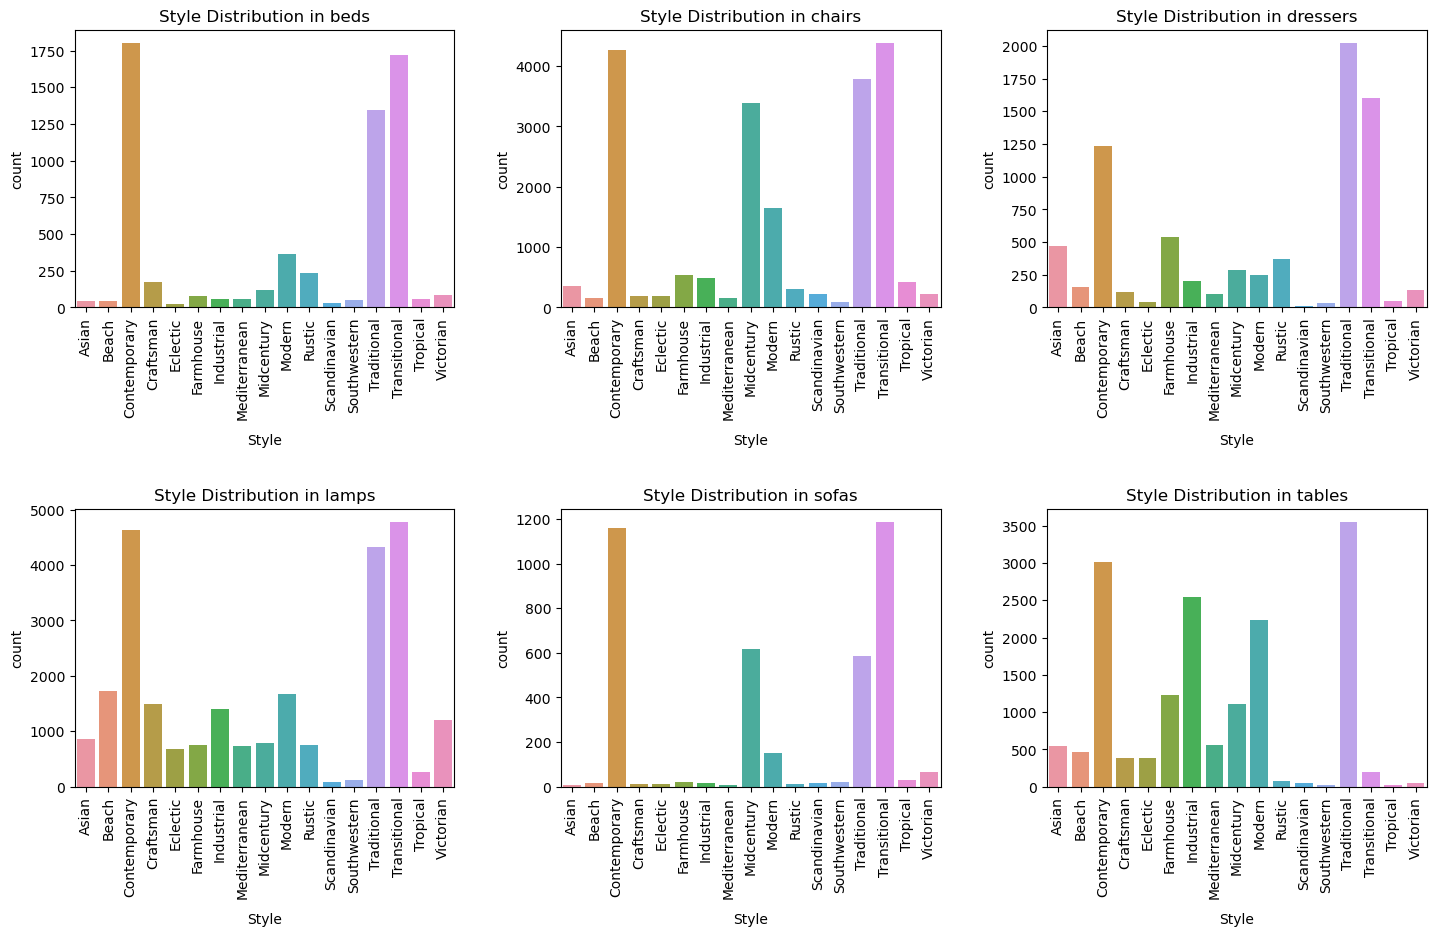

In [10]:
# Unique classes
classes = data_eda['Class'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(classes, 1):
    plt.subplot(2, 3, i)  # Adjust grid dimensions based on the number of classes
    sns.countplot(data=data_eda[data_eda['Class'] == class_name], x='Style')
    plt.title(f'Style Distribution in {class_name}')
    plt.xticks(rotation=90) 
    plt.xlabel('Style', labelpad=10)

plt.tight_layout(pad=3.0)
plt.show()

As we can see from the plot, the style distribution is very imbalanced. This will be treated with resampling later.

In [11]:
# Group by 'class' and count unique 'style'
style_counts_per_class = data_eda.groupby('Class')['Style'].nunique()

# Print the result
print(style_counts_per_class)

Class
beds        17
chairs      17
dressers    17
lamps       17
sofas       17
tables      17
Name: Style, dtype: int64


In [12]:
# Group by 'class' and 'style', then count occurrences
style_counts = data_eda.groupby(['Class', 'Style']).size()

# Print the result
print(style_counts.to_string())

Class     Style        
beds      Asian              44
          Beach              44
          Contemporary     1802
          Craftsman         176
          Eclectic           22
          Farmhouse          80
          Industrial         58
          Mediterranean      60
          Midcentury        116
          Modern            367
          Rustic            235
          Scandinavian       32
          Southwestern       48
          Traditional      1347
          Transitional     1717
          Tropical           55
          Victorian          83
chairs    Asian             349
          Beach             161
          Contemporary     4264
          Craftsman         196
          Eclectic          188
          Farmhouse         530
          Industrial        489
          Mediterranean     158
          Midcentury       3379
          Modern           1652
          Rustic            299
          Scandinavian      216
          Southwestern       92
          Tradit

## Train Test Split

This is done to prevent overfitting, provide different hyperparameter tuning and to provide better generalization for the model.

In [ ]:
df_clean = pd.read_csv('./data/df_clean_Task3.csv')

df_X = df_clean.drop(['Class', 'Style'], axis = 1)
df_Y = df_clean[['Class', 'Style']]
# split data 60% train, 20% val, %20 test
train_val_X, test_X, train_val_Y, test_Y = train_test_split( df_X, df_Y, shuffle=True, test_size=0.2, random_state=42)
train_X, val_X, train_Y, val_Y = train_test_split( train_val_X, train_val_Y, shuffle=True, test_size=0.25, random_state=42)

print(f"train_X shape: {train_X.shape}")
print(f"train_Y shape: {train_Y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_Y shape: {val_Y.shape}")
print(f"test_X shape: {val_X.shape}")
print(f"test_Y shape: {val_Y.shape}")

In [14]:
df_clean.head()

,ImgPath,Class,Style
0,data/Furniture_Data\beds\Asian\20027asian-cano...,beds,Asian
1,data/Furniture_Data\beds\Asian\20109asian-pane...,beds,Asian
2,data/Furniture_Data\beds\Asian\2537asian-platf...,beds,Asian
3,data/Furniture_Data\beds\Asian\2637asian-platf...,beds,Asian
4,data/Furniture_Data\beds\Asian\2709asian-platf...,beds,Asian


In [15]:
# Save to csv
train_X.to_csv("./data/X_train_before_transformed_Task3.csv", index=False)
train_Y.to_csv("./data/Y_train_before_transformed_Task3.csv", index=False)
val_X.to_csv("./data/X_val_Task3.csv", index=False)
val_Y.to_csv("./data/Y_val_Task3.csv", index=False)
test_X.to_csv("./data/X_test_Task3.csv", index=False)
test_Y.to_csv("./data/Y_test_Task3.csv", index=False)

### Plotting figures after splitting

In [3]:
train_Y = pd.read_csv("./data/Y_train_before_transformed_Task3.csv")

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


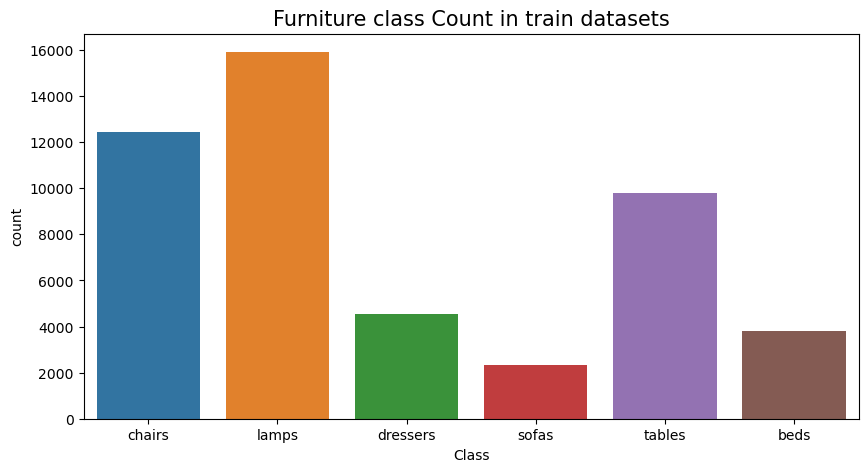

lamps       15907
chairs      12432
tables       9811
dressers     4543
beds         3798
sofas        2310
Name: Class, dtype: int64

In [4]:
# Plot bar graph
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.countplot(train_Y['Class'])
plt.title("Furniture class Count in train datasets", fontsize = 15)
plt.show()

train_Y['Class'].value_counts()

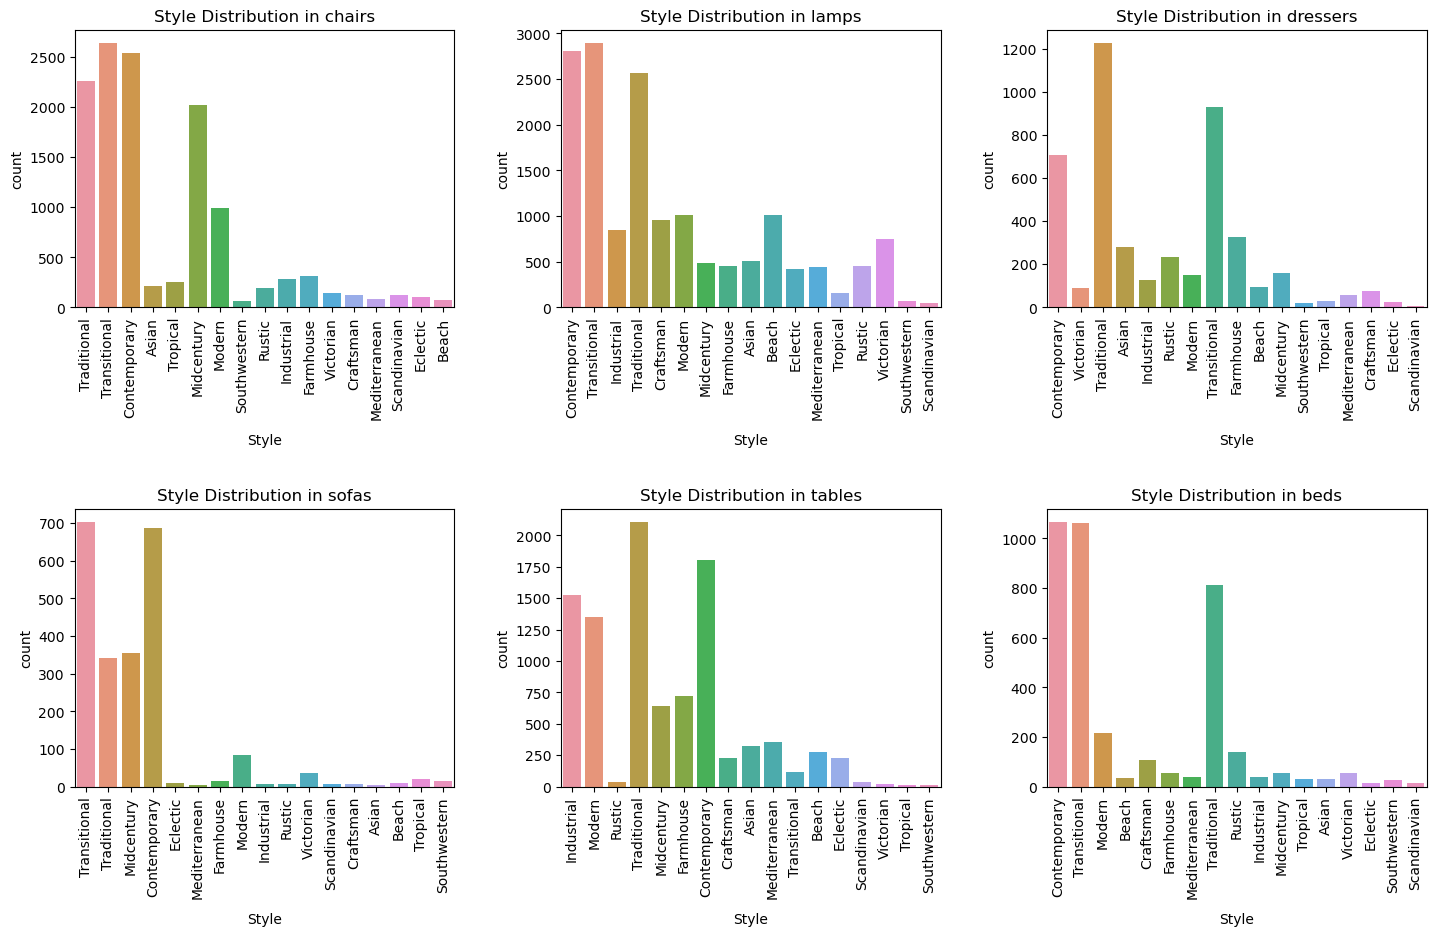

In [5]:
# Unique classes
classes = train_Y['Class'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(classes, 1):
    plt.subplot(2, 3, i)  # Adjust grid dimensions based on the number of classes
    sns.countplot(data=train_Y[train_Y['Class'] == class_name], x='Style')
    plt.title(f'Style Distribution in {class_name}')
    plt.xticks(rotation=90) 
    plt.xlabel('Style', labelpad=10)

plt.tight_layout(pad=3.0)
plt.show()

In [18]:
# Group by 'class' and 'style', then count occurrences
style_counts = train_Y.groupby(['Class', 'Style']).size()

# Print the result
print(style_counts.to_string())

Class     Style        
beds      Asian              31
          Beach              35
          Contemporary     1066
          Craftsman         108
          Eclectic           16
          Farmhouse          55
          Industrial         40
          Mediterranean      39
          Midcentury         53
          Modern            215
          Rustic            138
          Scandinavian       13
          Southwestern       27
          Traditional       813
          Transitional     1062
          Tropical           31
          Victorian          56
chairs    Asian             214
          Beach              79
          Contemporary     2543
          Craftsman         122
          Eclectic          109
          Farmhouse         312
          Industrial        286
          Mediterranean      87
          Midcentury       2017
          Modern            991
          Rustic            194
          Scandinavian      124
          Southwestern       60
          Tradit

## Handling class imbalance

To handle the imbalanced datasets, we will resample the datasets to the average occurences for all styles.

In [19]:
train_Y = pd.read_csv('./data/Y_train_before_transformed_Task3.csv')
style_counts = train_Y.groupby(['Class', 'Style']).size()
NUM_STYLES = len(train_Y['Style'].unique())
NUM_CLASSES = len(train_Y['Class'].unique())
total_occurences = style_counts.sum()
average_occurences = total_occurences // (NUM_STYLES * NUM_CLASSES)
print(f'Total classes: {NUM_CLASSES}')
print(f'Total styles: {NUM_STYLES}')
print(f'Total occurences: {total_occurences}')
print(f'Average occurences: {average_occurences}')

Total classes: 6
Total styles: 17
Total occurences: 48801
Average occurences: 478


This is done using **augmentation sequence**. 

The parameters for it are the following:

| Augmentation | Parameter | Description | Justification |
|--------------|------------|-------------|---------------|
| **Fliplr**   | 0.5        | Flips the image horizontally. | Horizontal flipping helps the model learn features invariant to left-right orientation, which is common in furniture. |
| **Crop**     | 0 to 0.1   | Randomly crops up to 10% of the image. | Random cropping simulates partial views and helps the model become robust to different object positions and sizes. |
| **GaussianBlur** | sigma: 0 to 0.5 | Applies Gaussian blur with a standard deviation between 0 and 0.5. | Introducing blur mimics out-of-focus images and helps the model learn to recognize objects with varying sharpness. |
| **LinearContrast** | 0.75 to 1.5 | Adjusts the contrast of the image. | Varying contrast helps the model generalize across images with different lighting conditions. |
| **Multiply** | 0.8 to 1.2 (per_channel=0.2) | Multiplies pixel values, with 20% chance to apply per channel. | Adjusting brightness and color intensity makes the model robust to lighting variations and color differences. |
| **Affine** - Scale | x: 0.8 to 1.2, y: 0.8 to 1.2 | Scales the image size. | Scaling simulates different distances from the camera, helping the model handle varying object sizes. |
| **Affine** - Translate | x: -0.2 to 0.2, y: -0.2 to 0.2 | Translates the image by up to 20% of its width or height. | Translation mimics shifts in object position within the frame, improving the model's ability to detect objects regardless of their position. |
| **Affine** - Rotate | -25 to 25 degrees | Rotates the image. | Rotation helps the model recognize objects from different angles and orientations. |
| **Affine** - Shear | -8 to 8 degrees | Applies a shear transformation. | Shearing introduces slight distortion, making the model robust to perspective changes. |

In [44]:
from imgaug import augmenters as iaa

def create_augmentation_sequence():
    return iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # random crops
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                   translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                   rotate=(-25, 25),
                   shear=(-8, 8))
    ])


After this step, we decide the number of samples for each style will be **500**.

In function `augment_images` we iterate through all the picture until the number reaches the `target_count` and save the augmented versions.

In [48]:
def augment_images(df, category, style, folder_path, target_count=500):
    # Filter DataFrame by category
    category_style_df = df[(df['Class'] == category) & (df['Style'] == style)]
    current_count = len(category_style_df)
    # print(category, style, current_count)
    seq = create_augmentation_sequence()

    output_category_dir = os.path.join(folder_path, category)
    if not os.path.exists(output_category_dir):
        os.makedirs(output_category_dir)
        
    output_style_dir = os.path.join(output_category_dir, style)
    if not os.path.exists(output_style_dir):
        os.makedirs(output_style_dir)

    # While loop to keep generating until we reach the target count
    while current_count < target_count:
        for _, row in category_style_df.iterrows():
            img_path = row['ImgPath']
            try:
                image = Image.open(img_path)
                image_np = np.array(image)  # Convert to numpy array for augmentation
                augmented_image_np = seq(images=[image_np])[0] 
                augmented_image = Image.fromarray(augmented_image_np)
                augmented_image.save(os.path.join(output_style_dir, f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{current_count}.png"))
                current_count += 1
                if current_count >= target_count:
                    break
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

    # return data

Load the data before augmentation

In [36]:
df_X_before_transformed = pd.read_csv('./data/X_train_before_transformed_Task3.csv')
df_Y_before_transformed = pd.read_csv('./data/Y_train_before_transformed_Task3.csv')
df_before_transformed = pd.concat([df_X_before_transformed, df_Y_before_transformed], axis=1)

In [37]:
df_before_transformed.head()

,ImgPath,Class,Style
0,data/Furniture_Data\chairs\Traditional\11591tr...,chairs,Traditional
1,data/Furniture_Data\lamps\Contemporary\2750con...,lamps,Contemporary
2,data/Furniture_Data\chairs\Transitional\22967t...,chairs,Transitional
3,data/Furniture_Data\lamps\Contemporary\33conte...,lamps,Contemporary
4,data/Furniture_Data\lamps\Contemporary\902cont...,lamps,Contemporary


Perform augmentation

In [49]:
augmentation_path = 'augmentation_Task3'
categories = df_before_transformed['Class'].unique()
styles = df_before_transformed['Style'].unique()
print(categories)
print(styles)

if not os.path.exists(augmentation_path):
    os.makedirs(augmentation_path)

for category in categories:
    for style in styles:
        augment_images(df_before_transformed, category, style, augmentation_path, 500)

['chairs' 'lamps' 'dressers' 'sofas' 'tables' 'beds']
['Traditional' 'Contemporary' 'Transitional' 'Industrial' 'Asian'
 'Tropical' 'Victorian' 'Craftsman' 'Midcentury' 'Modern' 'Rustic'
 'Farmhouse' 'Beach' 'Southwestern' 'Eclectic' 'Mediterranean'
 'Scandinavian']


Function `load_csv` is made to load the augmented data

In [62]:
def load_csv(dataset_folder, label_category, label_style, prompt = ""):
    # Folder path containing the images
    folder_path = dataset_folder  

    # List all files in the folder
    file_list = os.listdir(folder_path)
    data_csv = []
    for file_name in file_list:
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        # print(file_path)
        if os.path.isfile(file_path):
            data_csv.append([file_path, label_category, label_style])
    return data_csv

Finally, we load the augmented data into `augmentation_path` folder

In [63]:
data_augmenation_csv = []
augmentation_path = 'augmentation_Task3'
for category in categories:
    print("Accessing category " + category)
    for style in styles:
        print("\tAccessing style " + style)
        folder_path = os.path.join(augmentation_path, category, style)
        datas = load_csv(folder_path, category, style)
        data_augmenation_csv.extend(datas)

print('Load augmentation data successfully')

Accessing category chairs
	Accessing style Traditional
	Accessing style Contemporary
	Accessing style Transitional
	Accessing style Industrial
	Accessing style Asian
	Accessing style Tropical
	Accessing style Victorian
	Accessing style Craftsman
	Accessing style Midcentury
	Accessing style Modern
	Accessing style Rustic
	Accessing style Farmhouse
	Accessing style Beach
	Accessing style Southwestern
	Accessing style Eclectic
	Accessing style Mediterranean
	Accessing style Scandinavian
Accessing category lamps
	Accessing style Traditional
	Accessing style Contemporary
	Accessing style Transitional
	Accessing style Industrial
	Accessing style Asian
	Accessing style Tropical
	Accessing style Victorian
	Accessing style Craftsman
	Accessing style Midcentury
	Accessing style Modern
	Accessing style Rustic
	Accessing style Farmhouse
	Accessing style Beach
	Accessing style Southwestern
	Accessing style Eclectic
	Accessing style Mediterranean
	Accessing style Scandinavian
Accessing category dres

## Check augmented data

In this section we check if the data augmentation was successful.  

We will load the augmented data, plot it and check if resampling was successful.

In [82]:
df_augmentation = pd.DataFrame(data_augmenation_csv)
df_augmentation.rename(columns = {0:'ImgPath', 1:'Class', 2:'Style'}, inplace = True)
df_X_before_transformed = pd.read_csv('./data/X_train_before_transformed_Task3.csv')
df_Y_before_transformed = pd.read_csv('./data/Y_train_before_transformed_Task3.csv')
df_before_transformed = pd.concat([df_X_before_transformed, df_Y_before_transformed], axis=1)

df_sampling = pd.concat([df_before_transformed, df_augmentation], ignore_index=True)
df_sampling.to_csv('./data/df_sampling_Task3.csv', index = False)

# Group by the category and style and then sample
df_final = df_sampling.groupby(['Class', 'Style']).apply(lambda x: x.sample(min(len(x), 500))).reset_index(drop=True)
# df_final['Class'].value_counts()
df_final.to_csv('./data/df_final_Task3.csv', index = False)


In [83]:
df_final.head()

,ImgPath,Class,Style
0,augmentation_Task3\beds\Asian\7577asian-daybed...,beds,Asian
1,augmentation_Task3\beds\Asian\3110asian-platfo...,beds,Asian
2,data/Furniture_Data\beds\Asian\8108asian-platf...,beds,Asian
3,augmentation_Task3\beds\Asian\7815asian-platfo...,beds,Asian
4,augmentation_Task3\beds\Asian\7873asian-platfo...,beds,Asian


## Plotting the data

Let us plot the data grouped by `Class` to see the amount of each furniture type.

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


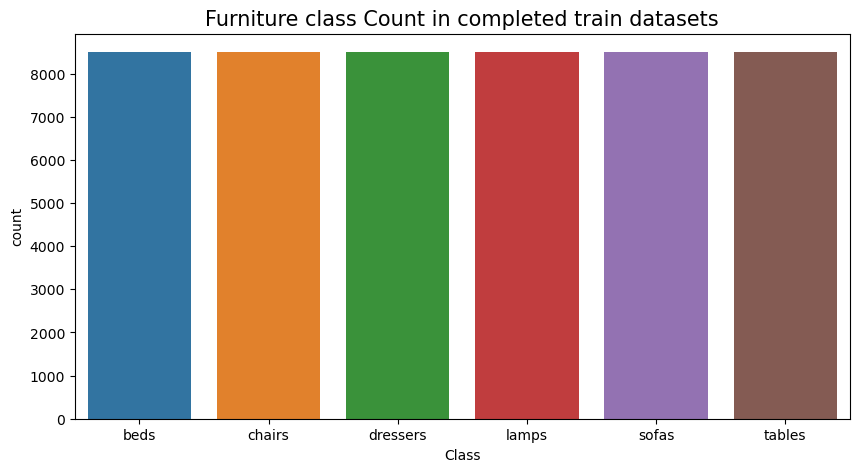

beds        8500
chairs      8500
dressers    8500
lamps       8500
sofas       8500
tables      8500
Name: Class, dtype: int64

In [84]:
# Plot bar graph
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.countplot(df_final['Class'])
plt.title("Furniture class Count in completed train datasets", fontsize = 15)
plt.show()
df_final['Class'].value_counts()

We can see that it is well distributed. Let us do the same with the style distribution.

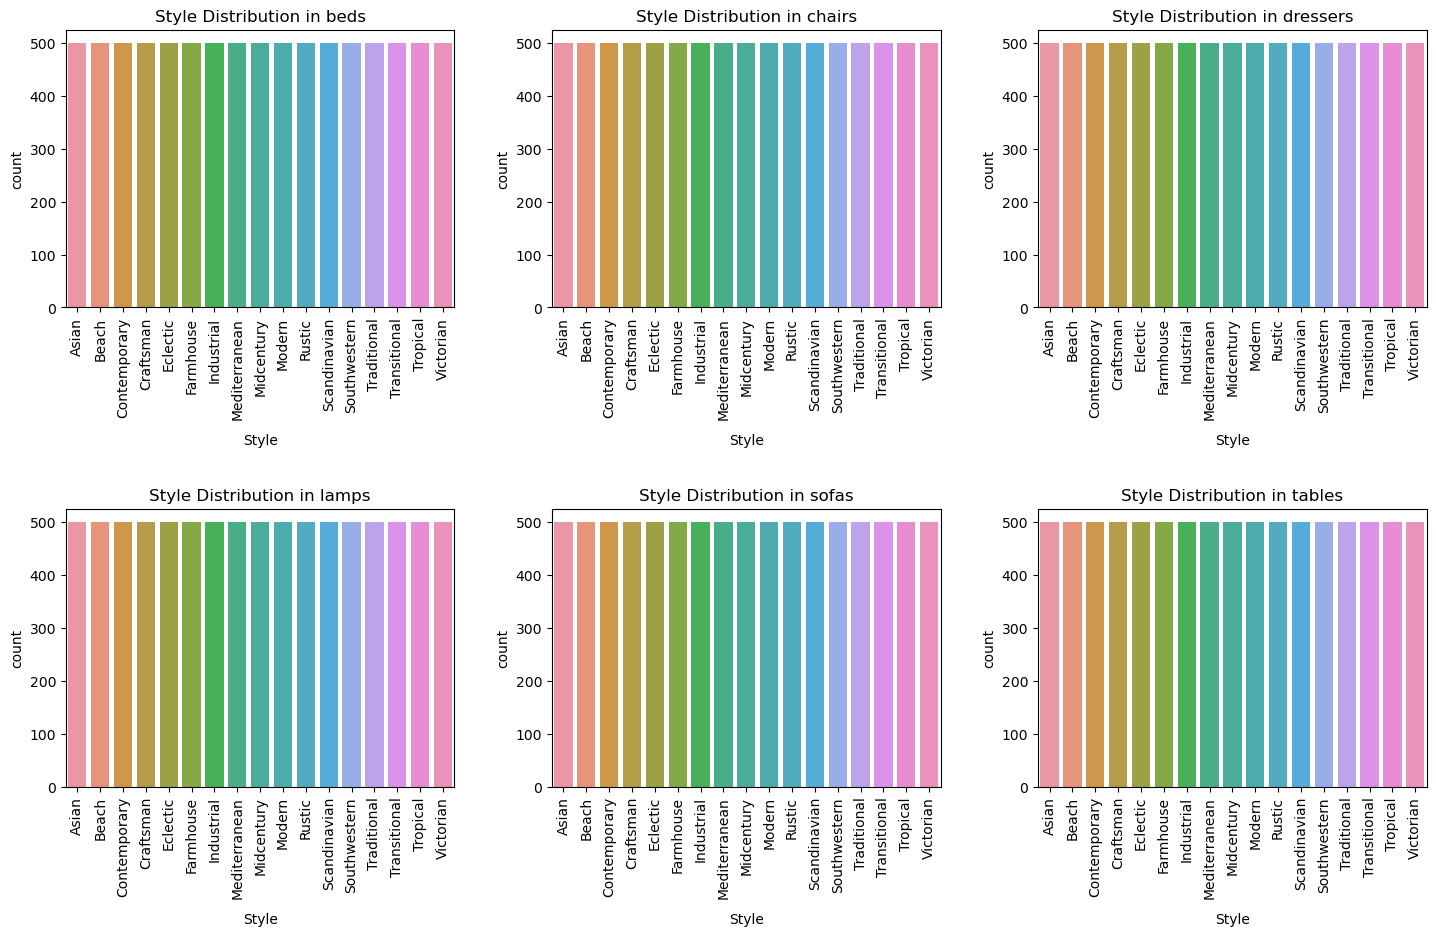

In [88]:
# Unique classes
classes = df_final['Class'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes, 1):
    plt.subplot(2, 3, i)  # Adjust grid dimensions based on the number of classes
    sns.countplot(data=df_final[df_final['Class'] == class_name], x='Style')
    plt.title(f'Style Distribution in {class_name}')
    plt.xticks(rotation=90) 
    plt.xlabel('Style', labelpad=10)

plt.tight_layout(pad=3.0)
plt.show()

In [89]:
# Group by 'class' and 'style', then count occurrences
style_counts = df_final.groupby(['Class', 'Style']).size()

# Print the result
print(style_counts.to_string())

Class     Style        
beds      Asian            500
          Beach            500
          Contemporary     500
          Craftsman        500
          Eclectic         500
          Farmhouse        500
          Industrial       500
          Mediterranean    500
          Midcentury       500
          Modern           500
          Rustic           500
          Scandinavian     500
          Southwestern     500
          Traditional      500
          Transitional     500
          Tropical         500
          Victorian        500
chairs    Asian            500
          Beach            500
          Contemporary     500
          Craftsman        500
          Eclectic         500
          Farmhouse        500
          Industrial       500
          Mediterranean    500
          Midcentury       500
          Modern           500
          Rustic           500
          Scandinavian     500
          Southwestern     500
          Traditional      500
          Trans

We can confirm that the style distribution resampling was successful. Thus, the EDA process for Task 3 can be called complete. 